# IMPORTS

In [1513]:
import spacy
from spacy import displacy
from collections import Counter
from spacy import tokenizer
import nltk

import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from nltk.corpus import state_union
from nltk.tokenize import PunktSentenceTokenizer
from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint

import io
import math
import requests
import PyPDF2
import spacy
import string
import re
import gensim
import glob
import os
from sklearn import svm
from sklearn import metrics

from sklearn.feature_extraction import text
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from pyLDA_visual import topic_visual
from Grid_Search_LDA import lda_gridsearch
from LDAGensim import lda_gensim_model
from sklearn.ensemble import RandomForestClassifier

nlp = spacy.load('en_core_web_sm')

##nltk.download('words')
##nltk.download('punkt')
##nltk.download('maxent_ne_chunker')
##nltk.download('averaged_perceptron_tagger')
##nltk.download('state_union')##

# Utility methods

In [1514]:
def get_org(doc):
    for i in doc.ents:
        if i.label_ == "ORG":
            organization = i.text
            return organization

In [1515]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [1516]:
def conf_matrix(y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred, labels=[0,1])
    labels=["no","yes"]
    hm = sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels = labels)
    hm.set_xlabel("Predicted" , size =18)
    hm.set_ylabel("Actual", size =18)

In [1517]:
def get_controversy_assessment(s,n):
    if s==0 and n==0:
        return 0
    if s==0 and n==1:
        return 1
    if s==0 and n==2:
        return 1
    if s==0 and n==3:
        return 1
    if s==1 and n==0:
        return 0
    if s==1 and n==1:
        return 1
    if s==1 and n==2:
        return 4
    if s==1 and n==3:
        return 4
    if s==2 and n==0:
        return 1
    if s==2 and n==1:
        return 4
    if s==2 and n==2:
        return 6
    if s==2 and n==3:
        return 6
    if s==3 and n==0:
        return 4
    if s==3 and n==1:
        return 4
    if s==3 and n==2:
        return 6
    if s==3 and n==3:
        return 6

In [1518]:
def get_flag_colour(x):
    if x == 0:
        return "Red"
    if x ==1:
        return "Orange"
    if x > 1 and x < 5:
        return "Yellow"
    if x > 5:
        return "Green"

In [1519]:
def get_subpillar(x):
    if x > 0 and x <= 7:
        return "Environment"
    if x > 7 and x <= 13:
        return "Customers"
    if x > 13 and x <= 17:
        return "Human rights and community"
    if x > 17 and x <= 24:
        return "Labour rights and supply chain"
    if x > 24:
        return "Governance"

In [1520]:
def get_pillar(x):
    if x > 0 and x <= 7:
        return "Environment"
    if x > 7 and x <= 24:
        return "Social"
    if x > 24:
        return "Governance"

In [1521]:
def get_status(x):
    if x == 0:
        return "Ongoing"
    if x == 1:
        return "Partially concluded"
    if x == 2:
        return "Concluded"

In [1522]:
def get_involvment(x):
    if x == 0:
        return "Direct"
    if x == 1:
        return "Indirect"
    if x == 2:
        return "Concluded"

In [1523]:
def get_scale(x):
    if x == 0:
        return "Very severe"
    if x == 1:
        return "Severe"
    if x == 2:
        return "Moderate"
    if x == 3:
        return "Minor"

In [1524]:
def get_nature_of_impact(x):
    if x == 0:
        return "Very serious"
    if x == 1:
        return "Serious"
    if x == 2:
        return "Medium"
    if x == 3:
        return "Minimal"

In [1526]:
def get_controversy_assessment_string(x):
    if x == 0:
        return "Very severe"
    if x == 1:
        return "Severe"
    if x == 4:
        return "Moderate"
    if x == 6:
        return "Minor"

# Reading dataset

In [1528]:
path = './dataset.xlsx'
ds = pd.read_excel(path)

ds["SCALE"] = ds["SCALE"].fillna(0)
ds["NATURE_OF_HARM"] = ds["NATURE_OF_HARM"].fillna(0)
ds["PERFORMANCE_INDICATOR"] = ds["PERFORMANCE_INDICATOR"].fillna(0)


# Method to get company name

In [1529]:
def get_company(ds):
    for index, x in ds.iterrows():
        temp = nlp(x["News"])
        ds.loc[index, "COMPANY_NAME"] = get_org(temp)
        if get_org(temp) == None :
            ds = ds.drop(index)
get_company(ds)
ds.head()

,Title,News,ESG_RELEVANT,PERFORMANCE_INDICATOR,SCALE,NATURE_OF_HARM,PILLAR,SUB_PILLAR,INVOLVED,STATUS,COMPANY_NAME,CONTROVERSY_ASSESSMENT,FLAG
0,Home Depot workers petition to form 1st store-...,NEW YORK (AP) â€”\n\nHome Depot workers in Phi...,1,20.0,1.0,2.0,1.0,4.0,0.0,0.0,AP,NaN,NaN
1,Ecowas threatens tough sanctions on Guinea,Guinea-Ecowas-Transition-Sanctions Ecowas thre...,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,the Economic Community of West African States,NaN,NaN
2,S/African court freezes pension payment for gr...,South Africa-Corruption-Lottery S/African cour...,1,25.0,1.0,1.0,1.0,5.0,0.0,1.0,APA-Johannesburg (South Africa,NaN,NaN
3,Siply Plans To Launch 1000 Phygital Branches R...,The company targets to launch 200 branches in ...,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Phygital,NaN,NaN
4,Denver judge rejects GOP residency complaint a...,A Democrat running to represent a state Senate...,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Senate,NaN,NaN


# Model - ESG relevant classification

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         5

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



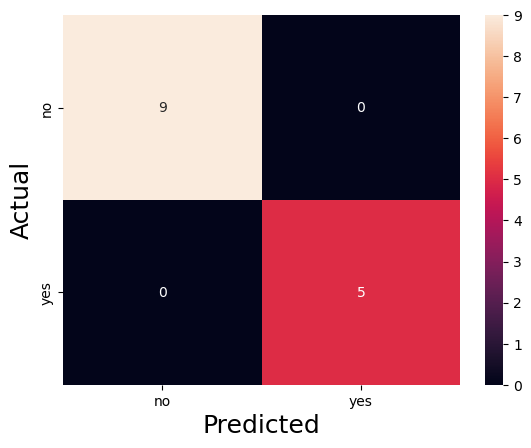

In [1530]:
stop_words = text.ENGLISH_STOP_WORDS

word_tf_vectorizer_esg = CountVectorizer(stop_words=stop_words)
word_tf = word_tf_vectorizer_esg.fit_transform(ds.News)

x_train, x_test, y_train, y_test = train_test_split(word_tf, ds.ESG_RELEVANT, test_size=0.2, random_state=42)

model_esg_relevance_classifier = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=10)
model_esg_relevance_classifier.fit(word_tf,ds.ESG_RELEVANT)

y_pred= model_esg_relevance_classifier.predict(x_test)
print(metrics.classification_report(y_test,y_pred))
conf_matrix(y_test, y_pred)

with open('model_esg_relevance_classifier', 'wb') as files:
    pickle.dump(model_esg_relevance_classifier, files)
    
with open('model_esg_relevance_classifier' , 'rb') as f:
    loaded_model_esg_relevance_classifier = pickle.load(f)

# Filtering ESG relevant news records

In [1531]:
for index, x in ds.iterrows():
    if x["ESG_RELEVANT"] == 0 :
        ds = ds.drop(index)
ds.head()

,Title,News,ESG_RELEVANT,PERFORMANCE_INDICATOR,SCALE,NATURE_OF_HARM,PILLAR,SUB_PILLAR,INVOLVED,STATUS,COMPANY_NAME,CONTROVERSY_ASSESSMENT,FLAG
0,Home Depot workers petition to form 1st store-...,NEW YORK (AP) â€”\n\nHome Depot workers in Phi...,1,20.0,1.0,2.0,1.0,4.0,0.0,0.0,AP,NaN,NaN
2,S/African court freezes pension payment for gr...,South Africa-Corruption-Lottery S/African cour...,1,25.0,1.0,1.0,1.0,5.0,0.0,1.0,APA-Johannesburg (South Africa,NaN,NaN
5,CTâ€™s big hospital systems are buying up priv...,"Original reporting by Katy Golvala, Erica E. P...",1,28.0,1.0,2.0,2.0,5.0,0.0,1.0,Yale New Haven,NaN,NaN
6,Here are the Trump properties at the center of...,CNN â€”\n\nNew York Attorney General Letitia J...,1,25.0,3.0,2.0,2.0,5.0,0.0,0.0,CNN,NaN,NaN
8,Louisiana regulators approve 475 MW Entergy so...,SOLAR: Louisiana regulators approve four utili...,1,3.0,1.0,2.0,0.0,1.0,0.0,0.0,MW for Entergy,NaN,NaN


# Model - Performance indicator classification

In [1532]:
topic_names = ['Bio-diversity and land user',
               'Toxic emission and waste',
               'Energy and climate change',
               'Water stress',
               'Operational waste',
               'Supplychain Management',
               'Other-evironment',
               'Anti-competitive practices',
               'Customer relations',
               'Privacy and data security',
               'Marketing and advertising',
               'Procust safety and quality',
               'Other-customers',
               'Impact on local communities',
               'Human rights concers',
               'Civil liberties',
               'Other-human rights and community',
               'Labour manangement relations',
               'Health and safety',
               'Collective Bargaining and community',
               'Discrimination and workforce diversity',
               'Child labour',
               'Supply chain labour standards',
               'Other-labour rights and supply chain',
               'Bribery and fraud',
               'Governance structures',
               'Contorversial investments',
               'Other-governance'
              ]

In [1533]:
word_tf_vectorizer = CountVectorizer(stop_words=stop_words)
word_tf = word_tf_vectorizer.fit_transform(ds.News)

# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=28,
                                      learning_decay=0.3,
                                      random_state=42
                                     )
lda_output = lda_model.fit(word_tf)

print("Log Likelihood: ", lda_model.score(word_tf))
print("Perplexity: ", lda_model.perplexity(word_tf))
print(lda_model.get_params())

transformed = lda_model.transform(word_tf)

with open('lda_model', 'wb') as files:
    pickle.dump(lda_model, files)
    
with open('lda_model' , 'rb') as f:
    loaded_lda_model = pickle.load(f)

a = [topic_names[np.argmax(distribution)] for distribution in transformed]
b = [np.max(distribution) for distribution in transformed]

esg_prob = pd.DataFrame(zip(a,b,transformed), columns=['PERFORMANCE_INDICATOR', 'probability', 'probabilities'])
ds["PERFORMANCE_INDICATOR"] = a

Log Likelihood:  -52573.3371553727
Perplexity:  2005.9961124756944
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.3, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 28, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


# Model - Nature of harm classification

In [1534]:
word_tf_vectorizer_esg_filtered = CountVectorizer(stop_words=stop_words)
word_tf_filtered = word_tf_vectorizer_esg_filtered.fit_transform(ds.News)

x_train, x_test, y_train, y_test = train_test_split(word_tf_filtered, ds.NATURE_OF_HARM, test_size=0.2, random_state=42)
model_nature_of_harm_classifier = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=10)
model_nature_of_harm_classifier.fit(x_train,y_train)

y_pred= model_nature_of_harm_classifier.predict(x_test)

with open('model_nature_of_harm_classifier', 'wb') as files:
    pickle.dump(model_nature_of_harm_classifier, files)
    
with open('model_nature_of_harm_classifier' , 'rb') as f:
    loaded_model_nature_of_harm_classifier = pickle.load(f)

# Model - Scale classification

In [1535]:
x_train, x_test, y_train, y_test = train_test_split(word_tf_filtered, ds.SCALE, test_size=0.2, random_state=42)
model_scale_classifier = svm.LinearSVC(multi_class='crammer_singer')
model_scale_classifier.fit(x_train,y_train)

y_pred= model_scale_classifier.predict(x_test)

with open('model_scale_classifier', 'wb') as files:
    pickle.dump(model_scale_classifier, files)
    
with open('model_scale_classifier' , 'rb') as f:
    loaded_model_scale_classifier = pickle.load(f)

# Model - Status classification

In [1536]:
x_train, x_test, y_train, y_test = train_test_split(word_tf_filtered, ds.STATUS, test_size=0.2, random_state=42)

model_status_classifier = svm.LinearSVC(multi_class='crammer_singer')
model_status_classifier.fit(x_train,y_train)

y_pred= model_status_classifier.predict(x_test)

with open('model_status_classifier', 'wb') as files:
    pickle.dump(model_status_classifier, files)
    
with open('model_status_classifier' , 'rb') as f:
    loaded_model_status_classifier = pickle.load(f)

# Model -  Involvement (Direct/Indirect)

In [1537]:
x_train, x_test, y_train, y_test = train_test_split(word_tf_filtered, ds.INVOLVED, test_size=0.2, random_state=42)
model_involvement_classifier = svm.LinearSVC(multi_class='crammer_singer')
model_involvement_classifier.fit(x_train,y_train)

y_pred= model_involvement_classifier.predict(x_test)

with open('model_involvement_classifier', 'wb') as files:
    pickle.dump(model_involvement_classifier, files)
    
with open('model_involvement_classifier' , 'rb') as f:
    loaded_model_involvement_classifier = pickle.load(f)

# Controversy assessment and flag calculation

In [1538]:
def contro_flag_calc(ds):
    for index, x in ds.iterrows():
        ds.loc[index, "CONTROVERSY_ASSESSMENT"] = get_controversy_assessment(x["SCALE"],x["NATURE_OF_HARM"])

    ds["FLAG"] = ds["CONTROVERSY_ASSESSMENT"] + ds["STATUS"] + ds["INVOLVED"]
    ds["FLAG_SCORE"] = ds["FLAG"]
    ds["name"] = ds["COMPANY_NAME"]
    return ds

ds = contro_flag_calc(ds)

In [1539]:
ds.head()

,Title,News,ESG_RELEVANT,PERFORMANCE_INDICATOR,SCALE,NATURE_OF_HARM,PILLAR,SUB_PILLAR,INVOLVED,STATUS,COMPANY_NAME,CONTROVERSY_ASSESSMENT,FLAG,FLAG_SCORE,name
0,Home Depot workers petition to form 1st store-...,NEW YORK (AP) â€”\n\nHome Depot workers in Phi...,1,Water stress,1.0,2.0,1.0,4.0,0.0,0.0,AP,4.0,4.0,4.0,AP
2,S/African court freezes pension payment for gr...,South Africa-Corruption-Lottery S/African cour...,1,Other-evironment,1.0,1.0,1.0,5.0,0.0,1.0,APA-Johannesburg (South Africa,1.0,2.0,2.0,APA-Johannesburg (South Africa
5,CTâ€™s big hospital systems are buying up priv...,"Original reporting by Katy Golvala, Erica E. P...",1,Other-governance,1.0,2.0,2.0,5.0,0.0,1.0,Yale New Haven,4.0,5.0,5.0,Yale New Haven
6,Here are the Trump properties at the center of...,CNN â€”\n\nNew York Attorney General Letitia J...,1,Child labour,3.0,2.0,2.0,5.0,0.0,0.0,CNN,6.0,6.0,6.0,CNN
8,Louisiana regulators approve 475 MW Entergy so...,SOLAR: Louisiana regulators approve four utili...,1,Procust safety and quality,1.0,2.0,0.0,1.0,0.0,0.0,MW for Entergy,4.0,4.0,4.0,MW for Entergy


# Result formatting

In [1540]:
def processed_output(ds):
    for index, x in ds.iterrows():
        ds.loc[index, "FLAG"] = get_flag_colour(x["FLAG"])
        ds.loc[index, "SUB_PILLAR"] = get_subpillar(topic_names.index(x["PERFORMANCE_INDICATOR"]))
        ds.loc[index, "PILLAR"] = get_pillar(topic_names.index(x["PERFORMANCE_INDICATOR"]))
        ds.loc[index, "STATUS"] = get_status(x["STATUS"])
        ds.loc[index, "INVOLVED"] = get_involvment(x["INVOLVED"])
        ds.loc[index, "SCALE"] = get_scale(x["SCALE"])
        ds.loc[index, "NATURE_OF_HARM"] = get_nature_of_impact(x["NATURE_OF_HARM"])
        ds.loc[index, "CONTROVERSY_ASSESSMENT"] = get_controversy_assessment_string(x["CONTROVERSY_ASSESSMENT"])
        return ds.sort_values("FLAG_SCORE", ascending = False)

ds = processed_output(ds)

# Method to export data

In [1541]:
def export_data(ds):
    json = ds.drop(['Title'], axis=1).to_json(orient ='records')

    os.chdir(r'../src/app')
    f = open("apiData.ts", "w")
    f.write("export const dataList = ")
    f.close()


    f = open("apiData.ts", "a")
    f.write(json)
    f.close()

    os.chdir(r'../../python_code')

# Read evaluation data

In [1542]:
eval_ds = pd.DataFrame(columns=ds.columns)

os.chdir(r'./evaluation_text')
my_files = glob.glob('*.txt')
for file in my_files:
    f = open(file, 'r', encoding="utf-8")
    df_to_append = pd.DataFrame([f.read()], columns=['News'])
    eval_ds = eval_ds.append(df_to_append)
    f.close()        
os.chdir(r'../')

C:\Users\admin\AppData\Local\Temp\ipykernel_9848\467530986.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_ds = eval_ds.append(df_to_append)


# Prediction for evaluation data

In [1543]:
word_tf = word_tf_vectorizer_esg.transform(eval_ds.News)
eval_ds["ESG_RELEVANT"]= loaded_model_esg_relevance_classifier.predict(word_tf)

In [1544]:
for index, x in eval_ds.iterrows():
    temp = nlp(x["News"])
    eval_ds.loc[index, "COMPANY_NAME"] = get_org(temp)
    if get_org(temp) == None :
        eval_ds = eval_ds.drop(index)

In [1545]:
word_tf_eval_filtered = word_tf_vectorizer_esg_filtered.transform(eval_ds.News)
eval_ds["NATURE_OF_HARM"]= loaded_model_nature_of_harm_classifier.predict(word_tf_eval_filtered)

In [1546]:
eval_transformed = loaded_lda_model.transform(word_tf_eval_filtered)

probability = [topic_names[np.argmax(distribution)] for distribution in eval_transformed]
probabilities = [np.max(distribution) for distribution in eval_transformed]

eval_esg_prob = pd.DataFrame(zip(probability,probabilities,eval_transformed), columns=['PERFORMANCE_INDICATOR', 'probability', 'probabilities'])

eval_ds["PERFORMANCE_INDICATOR"] = probability

In [1547]:
eval_ds["SCALE"]= loaded_model_scale_classifier.predict(word_tf_eval_filtered)

In [1548]:
eval_ds["STATUS"]= loaded_model_status_classifier.predict(word_tf_eval_filtered)

In [1549]:
eval_ds["INVOLVED"]= loaded_model_involvement_classifier.predict(word_tf_eval_filtered)

In [1550]:
eval_ds = contro_flag_calc(eval_ds)
eval_ds = processed_output(eval_ds)

In [1551]:
eval_ds.head()

,Title,News,ESG_RELEVANT,PERFORMANCE_INDICATOR,SCALE,NATURE_OF_HARM,PILLAR,SUB_PILLAR,INVOLVED,STATUS,COMPANY_NAME,CONTROVERSY_ASSESSMENT,FLAG,FLAG_SCORE,name
0,NaN,"""CNN â€”\n\nNew York Attorney General Letitia ...",1,Child labour,Minor,Medium,Social,Labour rights and supply chain,Direct,Ongoing,Trump,Minor,Green,6.0,Trump


# Data export

In [1552]:
export_data(eval_ds)